In [1]:
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
import numpy as np
import os, pathlib

In [2]:
'''!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip'''

fname = os.path.join(r"path to jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:] 
print(header) 
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [3]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1)) 
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

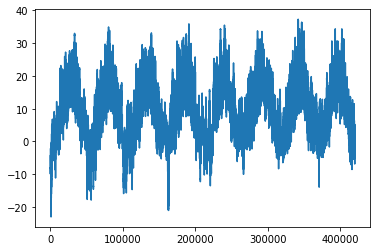

In [4]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

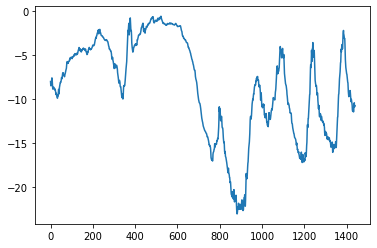

In [5]:
plt.plot(range(1440), temperature[:1440])

In [6]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [7]:
#Normalising training data

mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [8]:
#Aim: To predict temperature of day 6 given temperatures of day 5 (temparature taken every 24 hours and not ten minutes)

sampling_rate = 6
sequence_length = 120 #5 days, 24 hours
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(raw_data[:-delay],
                                                         targets=temperature[delay:],
                                                         sampling_rate=sampling_rate,
                                                         sequence_length=sequence_length,
                                                         shuffle=True,
                                                         batch_size=batch_size,
                                                         start_index=0,
                                                         end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(raw_data[:-delay],
                                                         targets=temperature[delay:],
                                                         sampling_rate=sampling_rate,
                                                         sequence_length=sequence_length,
                                                         shuffle=True,
                                                         batch_size=batch_size,
                                                         start_index=num_train_samples,
                                                         end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(raw_data[:-delay],
                                                         targets=temperature[delay:],
                                                         sampling_rate=sampling_rate,
                                                         sequence_length=sequence_length,
                                                         shuffle=True,
                                                         batch_size=batch_size,
                                                         start_index=num_val_samples)

In [9]:
#Each dataset yields a tuple (samples, targets), where samples is a batch of 256 samples, 
#each containing 120 consecutive hours of input data, 
#and targets is the corresponding array of 256 target temperatures

for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


In [10]:
#Establishing a baseline to beat: always predict that the 
#temperature 24 hours from now will be equal to the temperature right now
#Evaluating that prediction:

def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen



print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}") 
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.61


In [23]:
#Using a basic ML model also as a baseline model

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation='relu')(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
 keras.callbacks.ModelCheckpoint("climate_base_ml.keras",
 save_best_only=True)
] 

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
 epochs=10,
 validation_data=val_dataset,
 callbacks=callbacks)

model = keras.models.load_model("climate_base_ml.keras")

print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 10s 8ms/step - loss: 16.8946 - mae: 3.1607 - val_loss: 12.5470 - val_mae: 2.7815
Epoch 2/10
819/819 [==============================] - 6s 7ms/step - loss: 10.8136 - mae: 2.5915 - val_loss: 11.0004 - val_mae: 2.6053
Epoch 3/10
819/819 [==============================] - 7s 8ms/step - loss: 9.9279 - mae: 2.4788 - val_loss: 10.9852 - val_mae: 2.6343
Epoch 4/10
819/819 [==============================] - 6s 7ms/step - loss: 9.4052 - mae: 2.4092 - val_loss: 11.6050 - val_mae: 2.6955
Epoch 5/10
819/819 [==============================] - 6s 7ms/step - loss: 9.0239 - mae: 2.3588 - val_loss: 11.2024 - val_mae: 2.6642
Epoch 6/10
819/819 [==============================] - 6s 7ms/step - loss: 8.7693 - mae: 2.3245 - val_loss: 11.0891 - val_mae: 2.6242
Epoch 7/10
819/819 [==============================] - 6s 7ms/step - loss: 8.5344 - mae: 2.2928 - val_loss: 12.2646 - val_mae: 2.7791
Epoch 8/10
819/819 [==============================] - 6s 7ms/step 

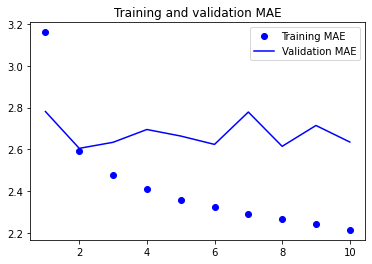

In [24]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [25]:
#Using Convo model

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation='relu')(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation='relu')(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation='relu')(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
 keras.callbacks.ModelCheckpoint("climate_conv.keras",
 save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
 epochs=10,
 validation_data=val_dataset,
 callbacks=callbacks)

model = keras.models.load_model("climate_conv.keras")
print("\n\n\n")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 17s 19ms/step - loss: 21.3948 - mae: 3.6355 - val_loss: 16.0923 - val_mae: 3.1603
Epoch 2/10
819/819 [==============================] - 16s 20ms/step - loss: 15.8027 - mae: 3.1618 - val_loss: 14.9351 - val_mae: 3.0637
Epoch 3/10
819/819 [==============================] - 16s 20ms/step - loss: 14.7254 - mae: 3.0510 - val_loss: 14.6289 - val_mae: 3.0050
Epoch 4/10
819/819 [==============================] - 17s 21ms/step - loss: 13.9763 - mae: 2.9679 - val_loss: 14.4419 - val_mae: 2.9979
Epoch 5/10
819/819 [==============================] - 17s 20ms/step - loss: 13.3477 - mae: 2.8940 - val_loss: 14.6089 - val_mae: 3.0106
Epoch 6/10
819/819 [==============================] - 18s 22ms/step - loss: 12.8557 - mae: 2.8349 - val_loss: 19.9405 - val_mae: 3.5600
Epoch 7/10
819/819 [==============================] - 17s 21ms/step - loss: 12.4113 - mae: 2.7822 - val_loss: 16.1561 - val_mae: 3.1830
Epoch 8/10
819/819 [============================

In [27]:
#Using LSTM

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
 keras.callbacks.ModelCheckpoint("climate_lstm.keras",
 save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
 epochs=10,
 validation_data=val_dataset,
 callbacks=callbacks)


Epoch 1/10
819/819 [==============================] - 37s 43ms/step - loss: 44.7633 - mae: 4.8893 - val_loss: 13.3963 - val_mae: 2.7879
Epoch 2/10
819/819 [==============================] - 35s 43ms/step - loss: 11.2445 - mae: 2.6007 - val_loss: 9.7204 - val_mae: 2.4267
Epoch 3/10
819/819 [==============================] - 34s 42ms/step - loss: 9.7120 - mae: 2.4396 - val_loss: 9.9920 - val_mae: 2.4575
Epoch 4/10
819/819 [==============================] - 34s 42ms/step - loss: 9.2871 - mae: 2.3823 - val_loss: 9.9012 - val_mae: 2.4484
Epoch 5/10
819/819 [==============================] - 35s 43ms/step - loss: 8.9968 - mae: 2.3418 - val_loss: 9.9994 - val_mae: 2.4485
Epoch 6/10
819/819 [==============================] - 35s 43ms/step - loss: 8.6894 - mae: 2.2979 - val_loss: 10.1708 - val_mae: 2.4690
Epoch 7/10
819/819 [==============================] - 35s 43ms/step - loss: 8.3904 - mae: 2.2584 - val_loss: 10.3723 - val_mae: 2.4904
Epoch 8/10
819/819 [==============================] - 35s

In [28]:
model = keras.models.load_model("climate_lstm.keras") 
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

1226/1226 [==============================] - 21s 16ms/step - loss: 10.4546 - mae: 2.5284
Test MAE: 2.53


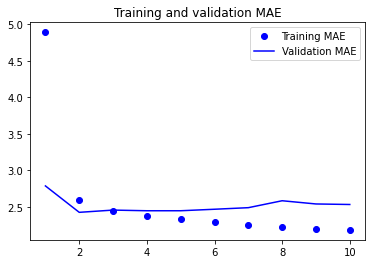

In [29]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [33]:
#Numpy implementation of simple RNN

import numpy as np

timesteps = 100
input_features = 32 
output_features = 64

inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features)) 
b = np.random.random((output_features,)) 

successive_outputs = []

for input_t in inputs: 
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
    
final_output_sequence = np.stack(successive_outputs, axis=0)

In [34]:
final_output_sequence

array([[0.99999982, 0.99999998, 0.99999995, ..., 0.99999997, 0.99999955,
        0.99999994],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       ...,
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ]])

In [35]:
#SimpleRNN() : Too simplistic because of vanishing gradient

In [36]:
#Recurrent Dropout

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)    #for dense
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
 keras.callbacks.ModelCheckpoint("climate_lstm_dropout.keras",
 save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
 epochs=15,
 validation_data=val_dataset,
 callbacks=callbacks) 

Epoch 1/15
819/819 [==============================] - 86s 102ms/step - loss: 29.8823 - mae: 4.0163 - val_loss: 10.1897 - val_mae: 2.4820
Epoch 2/15
819/819 [==============================] - 85s 104ms/step - loss: 15.0145 - mae: 3.0152 - val_loss: 9.3268 - val_mae: 2.3788
Epoch 3/15
819/819 [==============================] - 84s 102ms/step - loss: 14.1337 - mae: 2.9185 - val_loss: 9.3132 - val_mae: 2.3648
Epoch 4/15
819/819 [==============================] - 86s 105ms/step - loss: 13.6012 - mae: 2.8635 - val_loss: 9.4029 - val_mae: 2.3776
Epoch 5/15
819/819 [==============================] - 83s 102ms/step - loss: 13.0351 - mae: 2.8009 - val_loss: 9.2579 - val_mae: 2.3590
Epoch 6/15
819/819 [==============================] - 84s 103ms/step - loss: 12.5967 - mae: 2.7476 - val_loss: 9.3431 - val_mae: 2.3764
Epoch 7/15
819/819 [==============================] - 82s 100ms/step - loss: 12.4388 - mae: 2.7300 - val_loss: 9.1221 - val_mae: 2.3488
Epoch 8/15
819/819 [===========================

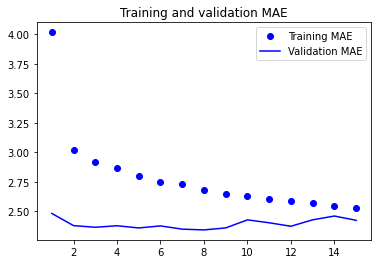

In [37]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [12]:
#Stacking layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint('climate_stacked_gru.keras', save_best_only=True)]

model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 120, 14)]         0         
_________________________________________________________________
gru_2 (GRU)                  (None, 120, 32)           4608      
_________________________________________________________________
gru_3 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 10,977
Trainable params: 10,977
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 146s 174ms/step - loss: 24.7870 - mae: 3.6811 - val_loss: 9.5362 - val_mae: 2.3876
Epoch 2/10
819/819 [==============================] - 137s 167ms/step - loss: 13.9813 - mae: 2.8995 - val_loss: 9.5405 - val_mae: 2.4015
Epoch 3/10
819/819 [==============================] - 140s 171ms/step - loss: 13.1799 - mae: 2.8122 - val_loss: 9.2418 - val_mae: 2.3567
Epoch 4/10
819/819 [==============================] - 138s 169ms/step - loss: 12.5053 - mae: 2.7403 - val_loss: 9.1680 - val_mae: 2.3478
Epoch 5/10
819/819 [==============================] - 139s 169ms/step - loss: 12.0379 - mae: 2.6922 - val_loss: 9.2420 - val_mae: 2.3654
Epoch 6/10
819/819 [==============================] - 145s 177ms/step - loss: 11.6409 - mae: 2.6448 - val_loss: 9.2972 - val_mae: 2.3681
Epoch 7/10
819/819 [==============================] - 138s 169ms/step - loss: 11.1929 - mae: 2.5983 - val_loss: 9.3310 - val_mae: 2.3702
Epoch 8/10
819/819 [=====================

In [15]:
#Using Bi-Directional LSTM

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(train_dataset, epochs=10, validation_data = val_dataset)

Epoch 1/10
819/819 [==============================] - 49s 57ms/step - loss: 32.2520 - mae: 4.1321 - val_loss: 13.3773 - val_mae: 2.8419
Epoch 2/10
819/819 [==============================] - 50s 60ms/step - loss: 11.4991 - mae: 2.6479 - val_loss: 12.6285 - val_mae: 2.7788
Epoch 3/10
819/819 [==============================] - 48s 59ms/step - loss: 10.4668 - mae: 2.5318 - val_loss: 10.7556 - val_mae: 2.5583
Epoch 4/10
819/819 [==============================] - 48s 58ms/step - loss: 9.2059 - mae: 2.3716 - val_loss: 9.9405 - val_mae: 2.4552
Epoch 5/10
819/819 [==============================] - 48s 58ms/step - loss: 8.6484 - mae: 2.2931 - val_loss: 9.7480 - val_mae: 2.4240
Epoch 6/10
819/819 [==============================] - 48s 59ms/step - loss: 8.1361 - mae: 2.2262 - val_loss: 9.7688 - val_mae: 2.4317
Epoch 7/10
819/819 [==============================] - 50s 61ms/step - loss: 7.8562 - mae: 2.1860 - val_loss: 9.7408 - val_mae: 2.4255
Epoch 8/10
819/819 [==============================] - 51